# Data processing

# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from constants import RANDOM_FOREST_PARAMS, NUM_FEATURES, CAT_FEATURES

from boruta import BorutaPy

from dask import delayed, compute
from dask.diagnostics import ProgressBar

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

import optuna
from optuna.samplers import TPESampler
from sklearn.linear_model import LogisticRegression

# Data Loading

In [2]:
X_list = []
y_list = []

for i in range(10):
    X = pd.read_parquet(f"../../../../data/interim/copper/X_train_bal/X_{i}.parquet")
    y = pd.read_parquet(f"../../../../data/interim/copper/y_train_bal/y_{i}.parquet")

    X_list.append(X)
    y_list.append(y)

X_train = pd.read_parquet("../../../../data/interim/copper/X_train.parquet")
y_train = pd.read_parquet("../../../../data/interim/copper/y_train_cat.parquet")

# Tunnig Random Forest


## Setting Up Pipeline Steps

In [3]:
over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")

numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
    ])

categorical_transformer = Pipeline(steps=[
    ('binary_encoder', BinaryEncoder())
])

preprocessor = ColumnTransformer(
        transformers=[
            ('num_pca', numeric_transformer, NUM_FEATURES),
            ('cat', categorical_transformer, CAT_FEATURES)
        ]
    )

rkf= RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

## Optimization

In [11]:
def objective(trial):
    params = dict()
    params['C'] = trial.suggest_float('C', 0.01, 10.0, log=True)
    params['penalty'] = 'l1'
    params['solver'] = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    params['class_weight'] = 'balanced'
    params['max_iter'] = trial.suggest_int('max_iter', 100, 1000)
    params['tol'] = trial.suggest_float('tol', 1e-4, 1e-2, log=True)
    
    steps_list = [('preprocessor', preprocessor),
                  ('over', over),
                  ('under', under),
                  ('classifier', LogisticRegression(**params))]
    
    pipe = ImbPipeline(steps_list)
    
    scores = cross_val_score(pipe, X_train, y_train, cv=rkf, scoring="roc_auc")

    return np.mean(scores), np.sqrt(np.std(scores))

study = optuna.create_study(directions=['maximize', 'minimize'], sampler=TPESampler())
study.optimize(objective, n_trials=1000)

[I 2024-10-28 02:07:12,319] A new study created in memory with name: no-name-e238c528-2e81-4d3a-bc19-4d30b1266748
[I 2024-10-28 02:07:12,911] Trial 0 finished with values: [0.607142857142857, 0.3059386111600502] and parameters: {'C': 0.9227315980468014, 'solver': 'liblinear', 'max_iter': 616, 'tol': 0.004478701622254578}.
[I 2024-10-28 02:07:13,487] Trial 1 finished with values: [0.6095999446290145, 0.28121723696306067] and parameters: {'C': 0.9146569025953727, 'solver': 'liblinear', 'max_iter': 694, 'tol': 0.00014957330080133917}.
[I 2024-10-28 02:07:14,043] Trial 2 finished with values: [0.5303294573643411, 0.23792628939386576] and parameters: {'C': 0.049006492452540615, 'solver': 'liblinear', 'max_iter': 241, 'tol': 0.008873362483123546}.
[I 2024-10-28 02:07:14,630] Trial 3 finished with values: [0.5, 0.0] and parameters: {'C': 0.02718377676193549, 'solver': 'liblinear', 'max_iter': 655, 'tol': 0.0020654706993095124}.
[I 2024-10-28 02:07:15,240] Trial 4 finished with values: [0.6021

In [12]:
optuna.visualization.plot_pareto_front(study, target_names=["mean ROC-AUC", "std ROC-AUC"])

In [13]:
study_df = study.trials_dataframe()
study_df[study_df['number'] == 280]

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_solver,params_tol,state
280,280,0.678838,0.270602,2024-10-28 02:10:14.783132,2024-10-28 02:10:15.561128,0 days 00:00:00.777996,0.119045,612,saga,0.000103,COMPLETE


In [35]:
#study_df.to_parquet("../../../../data/processed/copper/optuna_results_random_forest_raw_train.parquet")  # Save the results to a parquet file

In [22]:
params = {
    'C': 0.12,
    'penalty': 'l1',
    'solver': 'saga',
    'class_weight': 'balanced',
    'max_iter': 612,
    'tol': 0.0001
}

In [32]:
def importance_extimation(X, y, i):
    feat_selector = LogisticRegression(**params)

    feat_selector.fit(X, y)

    return feat_selector.coef_.ravel()

@delayed
def importance_experiment(X_list, y_list, i):
    
    rankings_list = [importance_extimation(X.values, y.values, i) for X, y in zip(X_list, y_list)]

    return rankings_list

In [33]:
# Create a list of delayed tasks
tasks = [importance_experiment(X_list, y_list, i) for i in range(5)]

# Use Dask to compute the results in parallel
with ProgressBar():
    experiments = compute(*tasks)

[########################################] | 100% Completed | 605.81 ms


In [34]:
exp_dfs = []

for exp in experiments:
    exp_dfs.append(pd.DataFrame(exp, columns=X_list[0].columns).reset_index())

exp_df = pd.concat(exp_dfs)
exp_df.reset_index(drop=True, inplace=True)

exp_median_df = exp_df.groupby("index").median()

plot_df = (
    exp_median_df.T
    .reset_index()
    .rename(columns={"index": "feature"})
    .melt(id_vars="feature", var_name="experiment", value_name="rank")
)

order = plot_df.groupby("feature")["rank"].mean().sort_values().index

<Axes: xlabel='rank', ylabel='feature'>

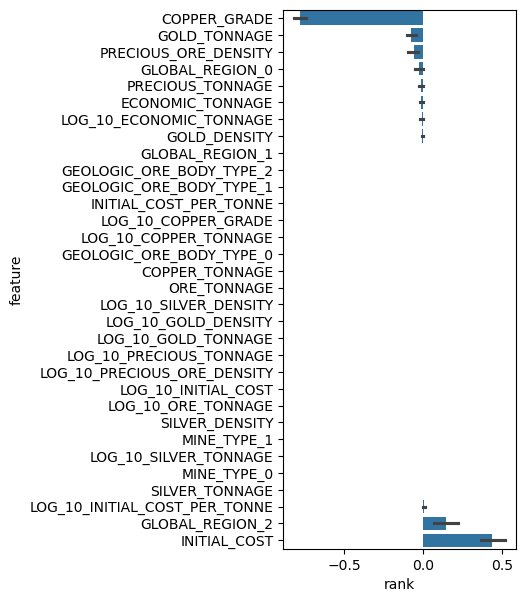

In [35]:
plt.figure(figsize=(3, 7))
sns.barplot(plot_df, y = "feature", x = "rank", orient="h", order=order)